In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('../../Code/')
from testWN import testWN as twm

In [2]:
%matplotlib notebook

# Get Network Information

In [3]:
inp_file = '../../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)

nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())
node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Load Result File

In [4]:
with open('./tempResults/02_results_sim_time.pkl', 'rb') as f:
    results = pickle.load(f)

<IPython.core.display.Javascript object>


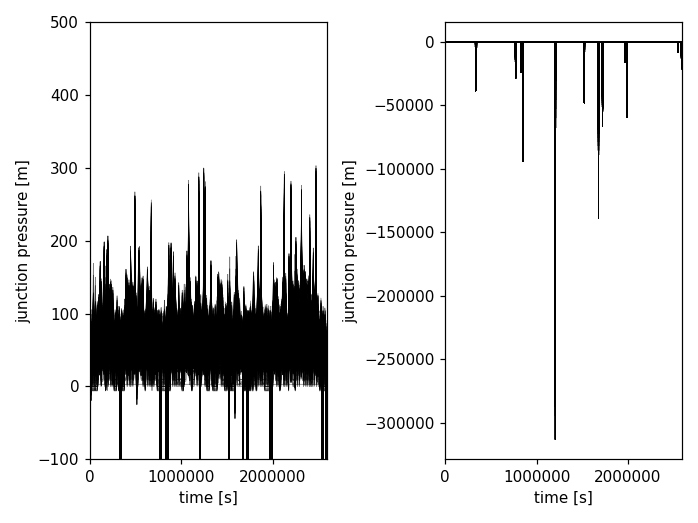

In [5]:
fig, ax = plt.subplots(1,2)
results.node['pressure'][node_names[2]].plot(legend=False, ax=ax[0], color='k', linewidth=0.5, alpha=0.5)
ax[0].set_ylim(-100,500)
results.node['pressure'][node_names[2]].plot(legend=False, ax=ax[1], color='k', linewidth=0.5, alpha=0.5)

ax[0].set_xlabel('time [s]')
ax[1].set_xlabel('time [s]')

ax[0].set_ylabel('junction pressure [m]')
ax[1].set_ylabel('junction pressure [m]')

fig.tight_layout()

<IPython.core.display.Javascript object>


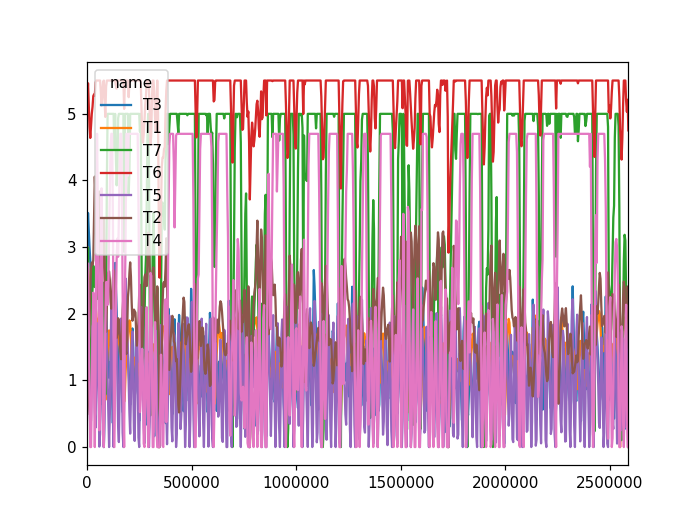

In [7]:
results.node['pressure'][node_names[0]].plot(legend=True)